In [2]:
!pip install --upgrade -q seaborn google-cloud-firestore python-dateutil


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [96]:
# Auth:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/tf/credentials.json"

# Data:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dateutil.parser

# Visualization:
import seaborn as sns

# Database:
from google.cloud import firestore

# TF:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


#print(tf.__version__)



In [4]:
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [5]:
# Create db instance: 
db = firestore.Client()

## Price helper functions

In [32]:
def get_price_data(id):
    #try:
        #output = pd.read_csv(f'data/price/{id}.csv', index_col='date')
        #output.drop(columns=['Unnamed: 0'], inplace = True)
        #return output
    #except FileNotFoundError:
    doc = db.collection('prices').document(id).get().to_dict()
    
    df = pd.DataFrame.from_dict(doc['priceData'])
    df = add_calculated_columns(df)
    df = convert_dates(df)
    df.to_csv(f'data/price/{id}.csv')

    # Read the file to lazily make sure that the dates are strings etc.
    # FIXME: Should probably be done some other way.
    output = pd.read_csv(f'data/price/{id}.csv', index_col='date')
    output.drop(columns=['Unnamed: 0'], inplace = True)
    return output

def convert_dates(df):
    for i, row in df.iterrows():
        df.at[i,'date'] = dateutil.parser.isoparse(row['date'])
    return df

def add_calculated_columns(price):
    lookbacks = [20, 50, 100, 200]
    
    #zscore = lambda x: (x[-1] - x.mean()) / x.std(ddof=1)
    
    
    for lookback in lookbacks:
        # Get the rolling average and std:
        price['average'] = price['close'].rolling(lookback).mean()
        price['std'] = price['close'].rolling(lookback).std()
        
        # Normalize distance to mean. This could be done with the data above but dont know how.
        price[f'zs-{lookback}'] = (price['close'] - price['average']) / price['std']

        # Get slope of rolling average and std
        price[f'ma-slope-{lookback}'] = price['average'] / price['average'].shift(1)
        price[f'ma-slope-{lookback}'] = price['std'] / price['average'].shift(1)

        # Drop the actual values since they carry no interest:
        price.drop(columns=['average', 'std'], inplace = True)
        
        # TODO: Add min/max[lookback] divided by last close
        # TODO: Add calculations for volume
        # TODO: Add calculations for owners
    return price

    

## Feature Columns

In [20]:
def get_feature_columns(price_data):
    output = price_data.drop(columns=[
        'high',
        'low', 
        'open',
        'close',
        'volume',
        'owners'
    ])
    return output

## Trade Helper functions

This part contains utils functions that will simplify the data creation

In [39]:
def get_trades(doc):
    """
    Converts a trade document into a dataframe of trades
    """

    df = pd.DataFrame.from_dict(doc['trades'])
    for i, row in df.iterrows():
        df.at[i,'result'] = row['exitPrice'] / row['entryPrice']

        try:
            df.at[i,'date'] = row['triggerDate']
        except:
            df.at[i,'date'] = None


    try:
        df.drop(columns=['entryDate', 'exitDate', 'triggerDate'], inplace = True)
    except:
        df.drop(columns=['entryDate', 'exitDate'], inplace = True)

    return df

def get_trade_df(filename):
    """
    Gets all trades and concatenates them into a single dataframe.
    It saves it to disk to avoid having to fetch it multiple times.
    """
    output = pd.DataFrame()
    err = False
    try:
        output = pd.read_csv(filename, index_col='date')
    except FileNotFoundError:
        err = True
    
    if (err == False):
        return output

    docs = db.collection('trades').stream()
    i = 0
    output = pd.DataFrame()
    
    for index, doc in enumerate(docs):
        print(index)
        price = get_price_data(doc.id)
        df = get_trades(doc.to_dict()) 
        # TODO: Convert dates here: source.strftime("%Y-%m-%d %H:%M:%S%z")
        try:
            df.to_csv(f'data/trades/{doc.id}.csv')
            read = pd.read_csv(f'data/trades/{doc.id}.csv', index_col='date')
            test = read.join(get_feature_columns(price))
            output = pd.concat([output, test])
            i = i+1


        except:
            print(doc.id)
            df.to_csv(f'data/trades/{doc.id}.csv')
            print('wrote')
            read = pd.read_csv(f'data/trades/{doc.id}.csv', index_col='date')
            print('read')
            test = read.join(get_feature_columns(price))
            print('join')
            output = pd.concat([output, test])
            print('concat')




    print(f'Found {i} documents, {len(output.index)} trades')
                
    output.to_csv(filename)

    return pd.read_csv(filename, index_col='date')



## Load Trades

In [40]:

trades = get_trade_df('/tf/data/trades/allTrades.csv')
trades.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Unnamed: 0 stockName  entryPrice  stockId  \
date                                                                   
2019-11-10 23:00:00+00:00           0       EQT      105.65  1001617   
2020-06-03 22:00:00+00:00           1       EQT      170.50  1001617   
2020-07-05 22:00:00+00:00           2       EQT      184.00  1001617   
2020-10-13 22:00:00+00:00           3       EQT      186.75  1001617   
2009-10-08 22:00:00+00:00           0  Eastnine       68.00   100687   

                           exitPrice            stockList    result     zs-20  \
date                                                                            
2019-11-10 23:00:00+00:00     141.00  Large Cap Stockholm  1.334595  2.406278   
2020-06-03 22:00:00+00:00     147.55  Large Cap Stockholm  0.865396  2.570386   
2020-07-05 22:00:00+00:00     171.50  Large Cap Stockholm  0.932065  2.339982   
2020-10-13 22:00:00+00:00     188.80  Large Cap Stockholm  1.010977  1.817743   
2009-10-08 22:00:00+00:00      74.00    Mid Cap Stockholm  1.088235  2.875387   

                           ma-slope-20     zs-50  ma-slope-50    zs-100  \
date                                                                      
2019-11-10 23:00:00+00:00     0.057286       NaN          NaN       NaN   
2020-06-03 22:00:00+00:00     0.047083  2.138433     0.124310  2.087838   
2020-07-05 22:00:00+00:00     0.053120  2.121880     0.096089  1.999881   
2020-10-13 22:00:00+00:00     0.055957  0.618434     0.112336  0.539262   
2009-10-08 22:00:00+00:00     0.035557  3.192040     0.036429  2.799438   

                           ma-slope-100    zs-200  ma-slope-200  
date                                                             
2019-11-10 23:00:00+00:00           NaN       NaN           NaN  
2020-06-03 22:00:00+00:00      0.135202       NaN           NaN  
2020-07-05 22:00:00+00:00      0.154610       NaN           NaN  
2020-10-13 22:00:00+00:00      0.117465  1.146368      0.200314  
2009-10-08 22:00:00+00:00      0.040015  1.646123      0.159546

In [88]:
# Remove the date as index column since its not unique:
trades.reset_index(inplace = True, drop = True) 
trades.drop(columns=['Unnamed: 0', 'stockName', 'stockList', 'entryPrice', 'exitPrice', 'stockId'], inplace=True)
train_dataset = trades.sample(frac=0.8, random_state=0)
test_dataset = trades.drop(train_dataset.index)


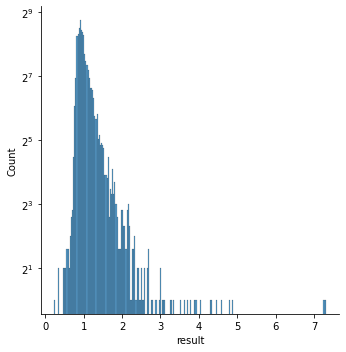

In [89]:
g = sns.displot(train_dataset, x="result")
g.fig.get_axes()[0].set_yscale('log', base=2)

In [90]:
train_dataset['result'].describe()
# Note that Mean > Median, indicating that the winrate is high enough 
# to get a profit even though its losing more than winning.

count    4452.000000
mean        1.065861
std         0.353663
min         0.232558
25%         0.889110
50%         0.974175
75%         1.127538
max         7.301942
Name: result, dtype: float64

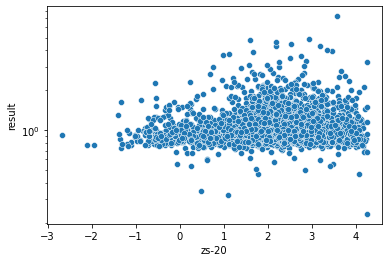

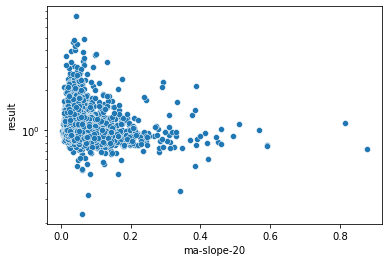

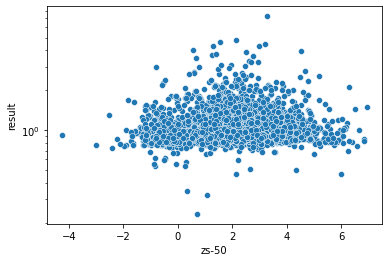

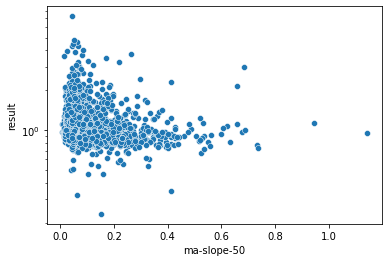

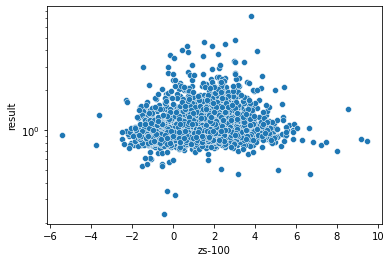

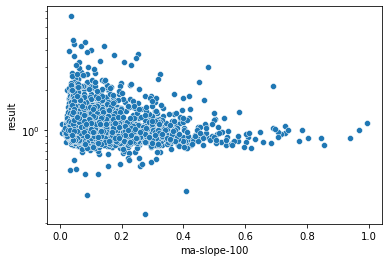

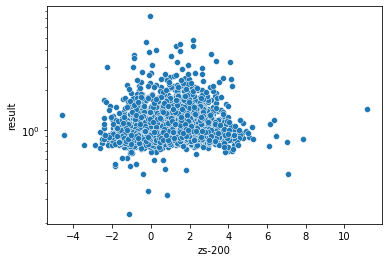

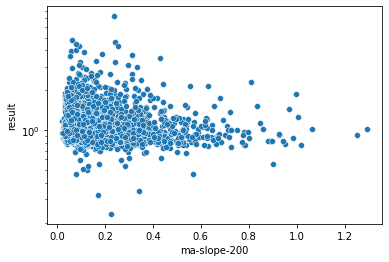

In [91]:
chartColumns = [
    'zs-20',
    'ma-slope-20',
    'zs-50',
    'ma-slope-50',
    'zs-100',
    'ma-slope-100',
    'zs-200',
    'ma-slope-200'
]

for col in chartColumns:
    g = sns.scatterplot(data=train_dataset, x=col, y="result")
    g.set(yscale="log")
    plt.show()


In [92]:
# Splut features from labels:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('result')
test_labels = test_features.pop('result')



stockId     zs-20  ma-slope-20     zs-50  ma-slope-50    zs-100  \
3986     5471  1.709902     0.061821  2.277139     0.063248  2.588124   
690    299737  0.370791     0.092559 -0.447818     0.198431 -1.025915   
944    460955  1.893459     0.055588 -0.594381     0.244674 -1.125651   
2565     5369  2.130999     0.032913  2.147198     0.043665  1.696477   
4028     5477  3.180914     0.066965  1.438219     0.081154  0.719715   
...       ...       ...          ...       ...          ...       ...   
3436     5436 -0.082671     0.118589 -0.154604     0.126330 -0.978465   
4256     5491  2.228073     0.047752  3.039079     0.044321 -0.303971   
5386   856638  2.805194     0.050635  1.821169     0.127091  1.930456   
4518     5528  2.250348     0.075177  1.910762     0.069574  1.141558   
4997   645576  1.985136     0.052135  1.932571     0.053646 -0.056267   

      ma-slope-100    zs-200  ma-slope-200  
3986      0.058480  0.034423      0.167880  
690       0.224767 -0.444139      0.284824  
944       0.362687 -1.564241      0.362622  
2565      0.045186  0.022039      0.082212  
4028      0.136733  1.320970      0.245290  
...            ...       ...           ...  
3436      0.221621 -1.234462      0.342384  
4256      0.247022 -0.682764      0.246459  
5386      0.134612  2.335076      0.102856  
4518      0.124329 -0.127664      0.403456  
4997      0.124227 -0.130105      0.225982  

[4452 rows x 9 columns]

## Data normalization:

In [97]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))


## Linear regression

In [98]:
zs100_lin_reg = np.array(train_features['zs-100'])

zs100_normalizer = preprocessing.Normalization(input_shape=[1,])
zs100_normalizer.adapt(zs100_lin_reg)



In [100]:
# Build the model
zs100_lin_reg_model = tf.keras.Sequential([
    zs100_normalizer,
    layers.Dense(units=1)
])

zs100_lin_reg_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [101]:
zs100_lin_reg_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [102]:
%%time
history = zs100_lin_reg_model.fit(
    train_features['zs-100'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


CPU times: user 11.5 s, sys: 1.57 s, total: 13 s
Wall time: 10.1 s


In [105]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


loss  val_loss  epoch
95   NaN       NaN     95
96   NaN       NaN     96
97   NaN       NaN     97
98   NaN       NaN     98
99   NaN       NaN     99

In [103]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


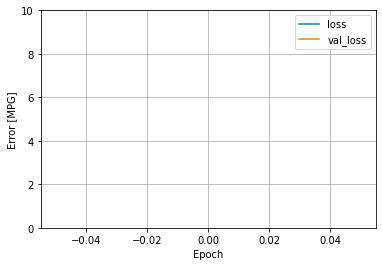

In [104]:
plot_loss(history)



## Features
- Avg volume
- STD
- 1,3,6,12m perf
- 1,3,6,12m relative perf (mot index)
- räntekurva
- breadth
- rsi, massa olika
- high massa olika
- low massa olika
- range massa olika
- Insiderköp
- nyheter

